In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
ratings = pd.read_csv("ml-100k/u.data",sep="\t",names=["user_id","item_id","rating","timestamp"])
users = pd.read_csv("ml-100k/u.user",sep="|",names=["user_id","age","gender","occupation","zip_code"])
items = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", names=[
    "item_id", "title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
])

In [5]:
data = ratings.merge(users,on="user_id").merge(items,on="item_id")
user_item_matrix = ratings.pivot(index="user_id",columns="item_id",values="rating").fillna(0)

In [6]:
data.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0


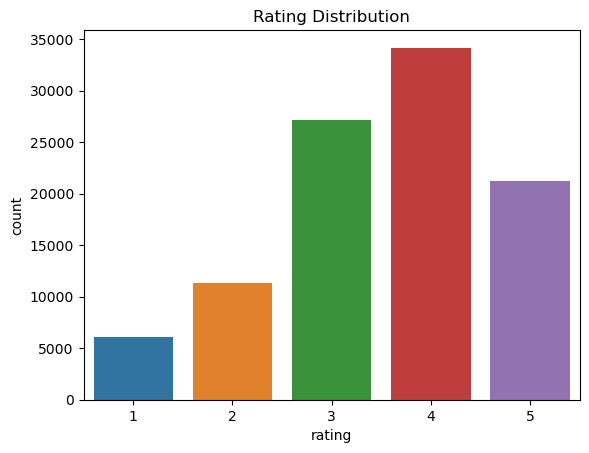

In [7]:
sns.countplot(x='rating',data=ratings)
plt.title('Rating Distribution')
plt.show()

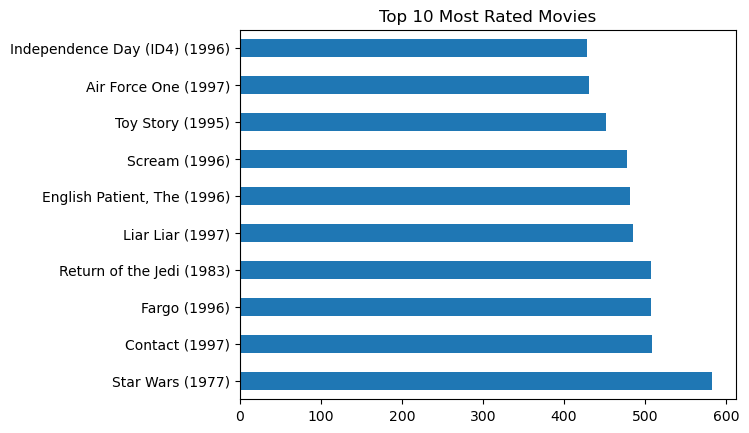

In [8]:
top_movies = data['title'].value_counts().head(10)
top_movies.plot(kind='barh',title='Top 10 Most Rated Movies')
plt.show()

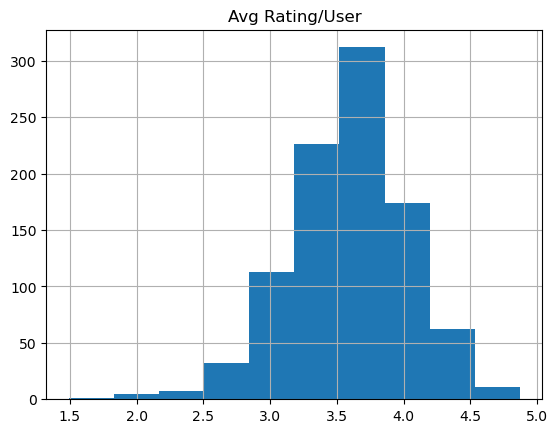

In [9]:
ratings.groupby('user_id')['rating'].mean().hist()
plt.title('Avg Rating/User')
plt.show()

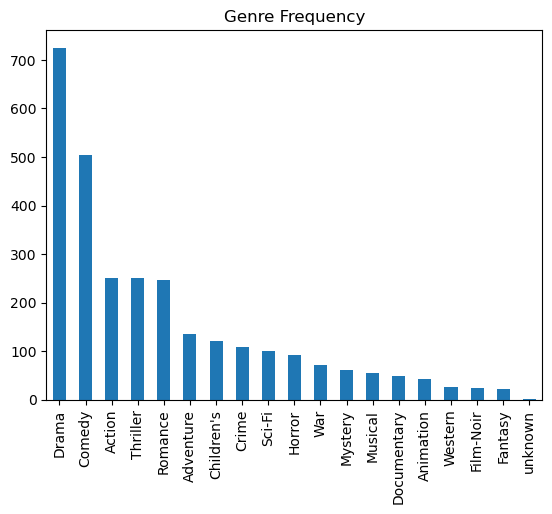

In [10]:
genres = items.iloc[:,5:]
genres.sum().sort_values(ascending=False).plot(kind='bar',title='Genre Frequency')
plt.show()

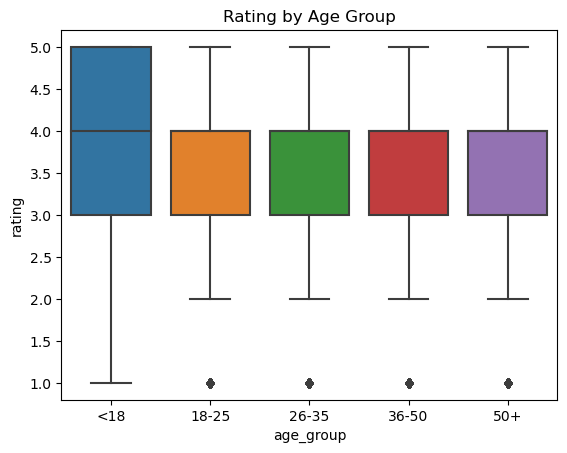

In [11]:
data['age_group'] = pd.cut(data['age'],bins=[0,18,25,35,50,100],labels=['<18','18-25','26-35','36-50','50+'])
sns.boxplot(x='age_group',y='rating',data=data)
plt.title('Rating by Age Group')
plt.show()

In [12]:
user_sim = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim,index=user_item_matrix.index,columns=user_item_matrix.index)

In [13]:
def user_cf_recommend(user_id,top_n=5):
    sim_users = user_sim_df[user_id].sort_values(ascending=False).index[1:]
    scores = user_item_matrix.loc[sim_users].T.dot(user_sim_df[user_id].loc[sim_users])
    sim_sum = user_sim_df[user_id].loc[sim_users].sum()
    pred = scores / sim_sum
    seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    return pred.drop(seen).sort_values(ascending=False).head(top_n)

In [14]:
item_sim = cosine_similarity(user_item_matrix.T)
item_sim_df = pd.DataFrame(item_sim, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [15]:
def item_cf_recommend(user_id, top_n=5):
    user_ratings = user_item_matrix.loc[user_id]
    pred = item_sim_df.dot(user_ratings).div(item_sim_df.sum(axis=1))
    seen = user_ratings[user_ratings > 0].index
    return pred.drop(seen).sort_values(ascending=False).head(top_n)

In [16]:
svd = TruncatedSVD(n_components=20)
svd_matrix = svd.fit_transform(user_item_matrix)
pred_svd = np.dot(svd_matrix, svd.components_)
rmse_svd = sqrt(mean_squared_error(user_item_matrix.values, pred_svd))

In [17]:
nmf = NMF(n_components=20)
nmf_user = nmf.fit_transform(user_item_matrix)
nmf_item = nmf.components_
pred_nmf = np.dot(nmf_user, nmf_item)
rmse_nmf = sqrt(mean_squared_error(user_item_matrix.values, pred_nmf))

C:\Users\saivi\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [18]:
class RatingDataset(Dataset):
    def __init__(self, ratings_df):
        self.users = torch.tensor(ratings_df['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(ratings_df['item_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings_df['rating'].values, dtype=torch.float)

    def __len__(self): return len(self.ratings)
    def __getitem__(self, idx): return self.users[idx], self.items[idx], self.ratings[idx]

In [19]:
class NCF(nn.Module):
    def __init__(self, n_users, n_items, emb_size=32):
        super().__init__()
        self.user_emb = nn.Embedding(n_users + 1, emb_size)
        self.item_emb = nn.Embedding(n_items + 1, emb_size)
        self.layers = nn.Sequential(
            nn.Linear(2 * emb_size, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item):
        x = torch.cat([self.user_emb(user), self.item_emb(item)], dim=1)
        return self.layers(x).squeeze()

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self, n_items):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_items, 64), nn.ReLU(), nn.Linear(64, 32))
        self.decoder = nn.Sequential(nn.Linear(32, 64), nn.ReLU(), nn.Linear(64, n_items))

    def forward(self, x): return self.decoder(self.encoder(x))

In [21]:
dataset = RatingDataset(ratings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

ncf_model = NCF(ratings['user_id'].max(), ratings['item_id'].max())
ae_model = AutoEncoder(user_item_matrix.shape[1])
loss_fn = nn.MSELoss()
ncf_optimizer = optim.Adam(ncf_model.parameters(), lr=0.01)
ae_optimizer = optim.Adam(ae_model.parameters(), lr=0.01)

In [22]:
for user, item, rating in dataloader:
    ncf_optimizer.zero_grad()
    preds = ncf_model(user, item)
    loss = loss_fn(preds, rating)
    loss.backward()
    ncf_optimizer.step()

In [23]:
ae_input = torch.tensor(user_item_matrix.values, dtype=torch.float)
ae_optimizer.zero_grad()
ae_preds = ae_model(ae_input)
ae_loss = loss_fn(ae_preds, ae_input)
ae_loss.backward()
ae_optimizer.step()

In [24]:
def chatbot():
    print("🤖 Hello! I'm your Movie Recommender Bot.")
    while True:
        try:
            user_id = int(input("👤 Enter your user ID (or 0 to exit): "))
            if user_id == 0: break
            print("\n🎯 Top 5 Movie Recommendations (User-based CF):")
            recs = user_cf_recommend(user_id)
            for movie_id in recs.index:
                title = items[items['item_id'] == movie_id]['title'].values[0]
                print(f"⭐ {title}")
        except Exception as e:
            print("⚠️ Error:", e)

chatbot()

🤖 Hello! I'm your Movie Recommender Bot.
👤 Enter your user ID (or 0 to exit): 1

🎯 Top 5 Movie Recommendations (User-based CF):
⭐ Schindler's List (1993)
⭐ E.T. the Extra-Terrestrial (1982)
⭐ One Flew Over the Cuckoo's Nest (1975)
⭐ English Patient, The (1996)
⭐ Scream (1996)
👤 Enter your user ID (or 0 to exit): 3

🎯 Top 5 Movie Recommendations (User-based CF):
⭐ Titanic (1997)
⭐ English Patient, The (1996)
⭐ Star Wars (1977)
⭐ Full Monty, The (1997)
⭐ Fargo (1996)
👤 Enter your user ID (or 0 to exit): 0
